In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
import re
from collections import Counter
import ast # to transform str to dic
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords # Import the stop word list
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline

## Loading Scraped data

In [2]:
toyota_df = pd.read_csv('./data/toyotaDataFrame.csv',index_col=0)
toyota_df['data'] = toyota_df['data'].map(lambda x: ast.literal_eval(x)) # Converting str col into dic

In [3]:
honda_df = pd.read_csv('./data/hondaDataFrame.csv',index_col=0)
honda_df['data'] = honda_df['data'].map(lambda x: ast.literal_eval(x)) # Converting str col into dic

In [4]:
honda_df.head()

,data,kind,subreddit,title,name,selftext,domain
0,"{'approved_at_utc': None, 'subreddit': 'Honda'...",t3,Honda,Sticky: Please check that your posts are in /r...,t3_7go7e3,It has come to our attention that /r/Honda's A...,self.Honda
1,"{'approved_at_utc': None, 'subreddit': 'Honda'...",t3,Honda,Bought a $300 NZD Civic Shuttle,t3_a6es4r,NaN,i.redd.it
2,"{'approved_at_utc': None, 'subreddit': 'Honda'...",t3,Honda,"I love night photography, and so does my CRZ",t3_a6f8fw,NaN,i.imgur.com
3,"{'approved_at_utc': None, 'subreddit': 'Honda'...",t3,Honda,Honda N600,t3_a6gsrs,NaN,i.redd.it
4,"{'approved_at_utc': None, 'subreddit': 'Honda'...",t3,Honda,Just gave her a wash!!!,t3_a6jcor,NaN,i.redd.it


### Removing Duplicated rows

In [5]:
toyota_df.drop_duplicates(subset=['subreddit', 'title', 'name', 'selftext', 'domain'],keep='first', inplace=True)
honda_df.drop_duplicates(subset=['subreddit', 'title', 'name', 'selftext', 'domain'],keep='first', inplace=True)

### Checking number of rows

In [6]:
print("toyotadf", toyota_df.shape)
print("hondadf", honda_df.shape)

toyotadf (908, 7)
hondadf (942, 7)


#### Insights:
1. Both data frames have more than 900 rows. There is enough data to train a model.
2. Frequency of classes are similar. There is no need to stratify or correct for imbalanced data.

### Replacing nulls with string null:

In [7]:
#Replacing null with 'null'
honda_df['selftext'].fillna('null9999', inplace=True) 
toyota_df['selftext'].fillna('null9999', inplace=True)

### Insights:
1. Some models might not accept rows with null values.
2. Replacing them with null string should fix that and not affect model prediction.


### Joining data Frames and Creating columns:

In [8]:
final_df = pd.concat([toyota_df, honda_df], axis=0, join='outer',ignore_index=False)
final_df = final_df.reset_index(drop=True)

#### Creating new columns from website information:

In [9]:
final_df['ups'] = final_df['data'].map(lambda x: x['ups'])
final_df['num_comments'] = final_df['data'].map(lambda x: x['num_comments'])
final_df['author'] = final_df['data'].map(lambda x: x['author'])

#### Creating Lable column:

In [10]:
final_df['label'] = final_df['subreddit'].map({'Toyota':0,'Honda':1})

#### Removing un-used columns:

In [11]:
drop_columns = ['data','kind','domain','name','subreddit']
final_df.drop(columns=drop_columns,axis=1,inplace=True)

### Insights:
1. The number of ups, comments and author name might be usefull for preditions.
2. The 2 data frames can be merged together since they have the similar information for different classes.
3. The label column will be the predicted variable.The value is equal to 1 if text is from Honda subredit. 

### Removing space,tab and breakline and stop words:

In [12]:
# nltk.download()  # Download text data sets, including stop words. Uncomment this if you did not download

In [13]:
def clean_text(text_to_clean):
    text_to_clean = re.sub( '[^a-zA-Z0-9]', ' ', text_to_clean) # subs charact in the brackets
    text_to_clean = re.sub( '\s+', ' ', text_to_clean).strip() ## subs tabs,newlines and "whitespace-like"
    words = text_to_clean.lower().split() ## convert to lowercase split indv words
    stops = set(stopwords.words('english')) #converting stop words to set
    meaningful_words = [w for w in words if not w in stops] # removing stop words
    return(" ".join(meaningful_words))

In [14]:
final_df['clean_title'] = final_df.apply(lambda x: clean_text(x['title']), axis=1)
final_df['clean_selftext'] = final_df.apply(lambda x: clean_text(x['selftext']), axis=1)

### Insights:
1. Double space, tabs and break lines usually are not usefull for preditions.

### Counting Nulls:

In [15]:
print("Total nulls:" , final_df.isnull().sum().sum())

Total nulls: 0


### Printing and checking class distribution:

In [16]:
display(final_df.head(2))
print("Final shape is: ", final_df.shape)
display("Class count: ", final_df['label'].value_counts())
display("Class percentage: ",final_df['label'].value_counts(normalize=True))

,title,selftext,ups,num_comments,author,label,clean_title,clean_selftext
0,YOUTUBE AND ALL OTHER VIDEO HOSTING SITE POSTI...,"FROM HENCEFORTH, ALL video links will be submi...",17,1,tunersharkbitten,0,youtube video hosting site posting policy redd...,henceforth video links submitted text posts fo...
1,Look what just showed up 😍😍😍,null9999,85,29,jawalter2014,0,look showed,null9999


Final shape is:  (1850, 8)


'Class count: '

1    942
0    908
Name: label, dtype: int64

'Class percentage: '

1    0.509189
0    0.490811
Name: label, dtype: float64

### Cheking most comon words for each class:

In [17]:
def wordListToFreqDict(wordlist):
    wordfreq = [wordlist.count(p) for p in wordlist]
    return dict(zip(wordlist,wordfreq))

def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

#### In post title:

In [18]:
#Honda
split_honda_series = final_df.loc[final_df['label']==1,:]['clean_title'].str.split()
words_honda = []
for value in split_honda_series:
    words_honda = words_honda + value
print("Honda word count length:", len(words_honda))

#Toyota
split_toyota_series = final_df.loc[final_df['label']==0,:]['clean_title'].str.split()
words_toyota = []
for value in split_toyota_series:
    words_toyota = words_toyota + value
print("Toyota word count length:", len(words_toyota))
display("Honda title common words",sortFreqDict(wordListToFreqDict(words_honda))[0:15])
display("Toyota title common words",sortFreqDict(wordListToFreqDict(words_toyota))[0:15])

Honda word count length: 6064
Toyota word count length: 5978


'Honda title common words'

[(200, 'honda'),
 (152, 'civic'),
 (114, 'accord'),
 (69, 'car'),
 (65, 'new'),
 (49, '2018'),
 (41, 'si'),
 (40, 'type'),
 (40, 'r'),
 (39, 'first'),
 (34, 'ex'),
 (31, 'help'),
 (29, 'miles'),
 (27, '2019'),
 (25, 'sport')]

'Toyota title common words'

[(235, 'toyota'),
 (110, 'camry'),
 (88, 'corolla'),
 (67, 'new'),
 (59, '2019'),
 (54, 'car'),
 (53, '2018'),
 (46, 'rav4'),
 (46, 'first'),
 (34, '4runner'),
 (33, 'highlander'),
 (32, 'question'),
 (30, 'old'),
 (29, 'miles'),
 (29, 'anyone')]

## Steaming and Lemmatizing

* In NPL steaming text can improve models.
* Will create 3 new columns one for each steaming method.

### Creating steaming Function:

In [19]:
porter=PorterStemmer()
lancaster=LancasterStemmer()
lemmatizer = WordNetLemmatizer()

def stemtext(sentence,steamer):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        if (str(steamer) == '<WordNetLemmatizer>'):
            stem_sentence.append(steamer.lemmatize(word))
        else:
            stem_sentence.append(steamer.stem(word))

        stem_sentence.append(" ")
    return "".join(stem_sentence)

### Using function to create steaming columns:

In [20]:
# For title column
final_df['clean_title_lemmat'] = final_df.apply(lambda x: stemtext(x['clean_title'], WordNetLemmatizer()), axis=1)
final_df['clean_title_lancast'] = final_df.apply(lambda x: stemtext(x['clean_title'], LancasterStemmer()), axis=1)
final_df['clean_title_port'] = final_df.apply(lambda x: stemtext(x['clean_title'],PorterStemmer()), axis=1)

In [21]:
# For self text column
final_df['clean_selftext_lemmat'] = final_df.apply(lambda x: stemtext(x['clean_title'], WordNetLemmatizer()), axis=1)
final_df['clean_selftext_lancast'] = final_df.apply(lambda x: stemtext(x['clean_title'], LancasterStemmer()), axis=1)
final_df['clean_selftext_port'] = final_df.apply(lambda x: stemtext(x['clean_title'],PorterStemmer()), axis=1)

In [22]:
#Checking data frame
final_df.head()

,title,selftext,ups,num_comments,author,label,clean_title,clean_selftext,clean_title_lemmat,clean_title_lancast,clean_title_port,clean_selftext_lemmat,clean_selftext_lancast,clean_selftext_port
0,YOUTUBE AND ALL OTHER VIDEO HOSTING SITE POSTI...,"FROM HENCEFORTH, ALL video links will be submi...",17,1,tunersharkbitten,0,youtube video hosting site posting policy redd...,henceforth video links submitted text posts fo...,youtube video hosting site posting policy redd...,youtub video host sit post policy reddit upload,youtub video host site post polici reddit upload,youtube video hosting site posting policy redd...,youtub video host sit post policy reddit upload,youtub video host site post polici reddit upload
1,Look what just showed up 😍😍😍,null9999,85,29,jawalter2014,0,look showed,null9999,look showed,look show,look show,look showed,look show,look show
2,"My ‘99 Camry just hit 420,666 miles!",null9999,270,43,renzonelisanchez,0,99 camry hit 420 666 miles,null9999,99 camry hit 420 666 mile,99 camry hit 420 666 mil,99 camri hit 420 666 mile,99 camry hit 420 666 mile,99 camry hit 420 666 mil,99 camri hit 420 666 mile
3,Something I made just for fun - Electric Toyota,null9999,1,1,caculo,0,something made fun electric toyota,null9999,something made fun electric toyota,someth mad fun elect toyot,someth made fun electr toyota,something made fun electric toyota,someth mad fun elect toyot,someth made fun electr toyota
4,Manual Transmission for 94-96 Celica,Who makes the manual transmissions for the 94-...,2,14,BadSeed2666,0,manual transmission 94 96 celica,makes manual transmissions 94 96 celicas someb...,manual transmission 94 96 celica,man transmit 94 96 celic,manual transmiss 94 96 celica,manual transmission 94 96 celica,man transmit 94 96 celic,manual transmiss 94 96 celica


## Dealing with empty rows post lemmatizing:

* After lemmatizer the row 1239 had no word in the title(only emoji).
* Dropping drop of 1 row will not have significant affect in the model.

In [23]:
#droping column where lemmatizer left no text
display(final_df[final_df['clean_title'].str.len()< 1])
final_df = final_df[~(final_df['clean_title'].str.len()< 1)]

,title,selftext,ups,num_comments,author,label,clean_title,clean_selftext,clean_title_lemmat,clean_title_lancast,clean_title_port,clean_selftext_lemmat,clean_selftext_lancast,clean_selftext_port
1239,❄️🏎😁,null9999,7,0,pretty_skinny_ninja,1,,null9999,,,,,,


In [24]:
#droping column where title after cleaning only has manufacture name
display(final_df[final_df['clean_title']=='toyota'])
final_df = final_df[~(final_df['clean_title']=='toyota')]

,title,selftext,ups,num_comments,author,label,clean_title,clean_selftext,clean_title_lemmat,clean_title_lancast,clean_title_port,clean_selftext_lemmat,clean_selftext_lancast,clean_selftext_port
380,What Toyota is this?,null9999,13,6,kujian,0,toyota,null9999,toyota,toyot,toyota,toyota,toyot,toyota


* During the regression honda and toyota words will be removed
* These words make too easy for the model to predict.

## Creating Word Cloud:

In [25]:
# # Start with one review:
# text = final_df['clean_title'][2]
# Join all titles of each Car Maker:
honda = " ".join(review for review in final_df[final_df["label"]==1]['clean_title'])
toyota = " ".join(review for review in final_df[final_df["label"]==0]['clean_title'])

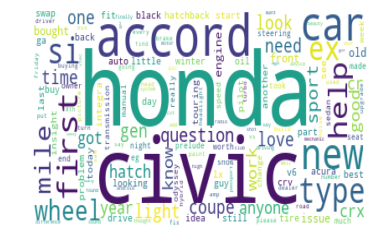

In [26]:
# Honda
# Join all titles:
honda = " ".join(review for review in final_df[final_df["label"]==1]['clean_title'])
#Create and generate a word cloud image:
wordcloud_honda = WordCloud(collocations=False,background_color="white", max_words=150).generate(honda)

# Display the generated image:
plt.imshow(wordcloud_honda, interpolation='bilinear',aspect="auto")
plt.axis("off")
# store to file
plt.savefig("./images/honda_word_cloud.png", format="png")
plt.show()



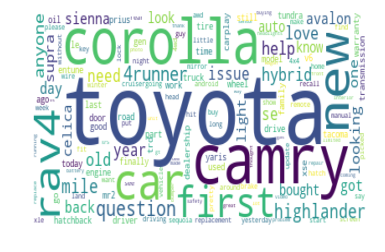

In [27]:
# Toyota
# Join all titles:
toyota = " ".join(review for review in final_df[final_df["label"]==0]['clean_title'])
# Create and generate a word cloud image:
wordcloud_toyota = WordCloud(collocations=False,background_color="white", max_words=150).generate(toyota)

# Display the generated image:
plt.imshow(wordcloud_toyota, interpolation='bilinear',aspect="auto")
plt.axis("off")

# store to file
plt.savefig('./images/toyota_word_cloud.png', format="png")

# show image
plt.show()


# Saving data in CSV

In [28]:
final_df.to_csv('./data/final_df.csv', encoding='utf-8',index_label=False)